In [1546]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


In [1547]:

train_df = pd.read_csv('data_train.csv', index_col=[0], parse_dates=[0])
train_data = train_df['Natural_Gas_US_Henry_Hub_Gas']

test_df = pd.read_csv('data_test.csv', index_col=[0], parse_dates=[0])
test_data = test_df['Natural_Gas_US_Henry_Hub_Gas']

data = pd.concat([train_df, test_df], ignore_index=False)

data = data.fillna(method='ffill')
data = data.fillna(method='bfill')
data.head()


<ipython-input-1547-5edc7bc82f3d>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
<ipython-input-1547-5edc7bc82f3d>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')


,Brent_Crude_Oil,WTI_Crude_Oil,Electricity_Price_USA,Heating_Oil_Price_USA,Natural_Gas_Imports_From_Canada_USA,Natural_Gas_Imports_USA,Natural_Gas_Rotary_Rig_Count_USA,Natural_Gas_Total_Consumption_USA,Total_Natural_Gas_Marketed_Production_USA,Total_Natural_Gas_Underground_Storage_Volume_USA,...,Services_PMI,Chemical_Fertilizers_Manufactured_(actual_weight)_Accumulated_YoY,Crude_Steel_Accumulated_YoY,Real_Estate_Floor_Space_of_Commercialized_Buildings_Sold_Accumulated_YoY,Motor_Vehicles_Accumulated_YoY,EU_Aggregated_Gas_Storage_Inventory,EU_Aggregated_LNG_System_Inventory,high_temperature,low_temperature,Natural_Gas_US_Henry_Hub_Gas
date,,,,,,,,,,,,,,,,,,,,,
2003-09-30,28.09,29.19,7.61,1.373,266841.0,320676.0,936.0,1428550.0,1638820.0,7173310.0,...,51.1,26.814653,37.299872,36.159903,32.771306,364.844,3665.74,83.0,51.0,4.62095
2003-10-31,27.88,29.24,7.39,1.373,273482.0,331005.0,941.0,1553190.0,1694600.0,7456710.0,...,51.1,26.814653,37.299872,36.159903,32.771306,364.844,3665.74,73.0,33.0,4.63391
2003-11-30,28.95,30.33,7.19,1.395,269978.0,316721.0,952.0,1753640.0,1620080.0,7341440.0,...,51.1,26.814653,37.299872,36.159903,32.771306,364.844,3665.74,76.0,27.0,4.49167
2003-12-31,30.30,32.51,7.14,1.456,324089.0,364161.0,959.0,2263660.0,1673110.0,6865770.0,...,51.1,26.814653,37.299872,36.159903,32.771306,364.844,3665.74,58.0,16.0,6.14000
2004-01-31,29.53,33.16,7.22,1.566,319783.0,373195.0,955.0,2675830.0,1674400.0,6051840.0,...,51.1,26.814653,37.299872,36.159903,32.771306,364.844,3665.74,50.0,-7.0,6.15053


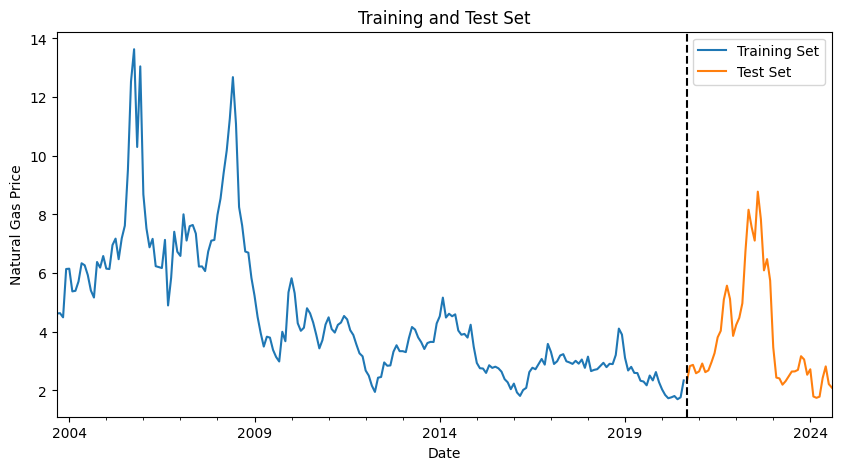

In [1548]:
fig, ax = plt.subplots(figsize=(10, 5))
train_data.plot(ax=ax, label='Training Set')
test_data.plot(ax=ax, label='Test Set')
ax.axvline('2020-09-30', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Training and Test Set')
ax.set_xlabel('Date')
ax.set_ylabel('Natural Gas Price')
plt.show()

In [1549]:
def optimal_components_by_variance(data, variance_threshold=0.99):
    rate_dataset = data.iloc[:, :-1]
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(rate_dataset)

    pca_full = PCA()
    pca_full.fit(data_scaled)

    cumulative_var = pca_full.explained_variance_ratio_.cumsum()
    optimal_n = np.argmax(cumulative_var >= variance_threshold) + 1

    print(f"Components needed for {variance_threshold*100}% variance: {optimal_n}")
    print(f"Actual variance explained: {cumulative_var[optimal_n-1]:}")

    return optimal_n, scaler


In [1550]:

def PCA_analysis(data, variance_threshold=0.99):
    optimal_n, scaler = optimal_components_by_variance(data, variance_threshold)

    rate_dataset = data.iloc[:, :-1]
    data_scaled = scaler.fit_transform(rate_dataset)

    pca = PCA(n_components=optimal_n, svd_solver="auto", random_state=2022)
    pcs_overtime = pca.fit_transform(data_scaled)

    pcs_overtime_df = pd.DataFrame(
        data=pcs_overtime,
        columns=[f'PC{i+1}' for i in range(optimal_n)],
        index=rate_dataset.index
    )

    pcs_shape_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(optimal_n)],
        index=rate_dataset.columns
    )

    print(f'\nExplained variance ratio: {pca.explained_variance_ratio_} \n')
    print(f'Cumulative explained variance: {pca.explained_variance_ratio_.cumsum()} \n')
    print(f'Total variance explained: {pca.explained_variance_ratio_.sum():}')

    return pcs_shape_df, pcs_overtime_df, pca, scaler

pcs_shape_df, pcs_overtime_df, pca_model, scaler = PCA_analysis(data, variance_threshold=0.9)


Components needed for 90.0% variance: 16
Actual variance explained: 0.9013597784953349

Explained variance ratio: [0.27760023 0.17190793 0.08936963 0.06706795 0.05025616 0.04081616
 0.03647308 0.03377746 0.02721844 0.02319744 0.01703308 0.01596122
 0.01526554 0.01254488 0.01166297 0.01120762] 

Cumulative explained variance: [0.27760023 0.44950815 0.53887779 0.60594574 0.6562019  0.69701806
 0.73349114 0.76726859 0.79448704 0.81768448 0.83471755 0.85067877
 0.86594432 0.87848919 0.89015216 0.90135978] 

Total variance explained: 0.9013597784953348


In [1568]:
feature_importance = pcs_shape_df.abs().sum(axis=1).sort_values(ascending=False)
print("Most important original features (across all PCs): \n")
print("Feature:                                                        Explained Variance: \n")
print(feature_importance.head(16))

Most important original features (across all PCs): 

Feature:                                                        Explained Variance: 

CLI_Comp_Monetary_Aggregates_IND                                     1.873161
CLI_Comp_Consumer_Confidence_GBR                                     1.624241
CLI_Comp_Construction_USA                                            1.594911
Chemical_Fertilizers_Manufactured_(actual_weight)_Accumulated_YoY    1.572320
Total_Natural_Gas_Underground_Storage_Volume_USA                     1.567397
M_PMI_Comp_Main_Raw_Material_Purchase_Price                          1.561806
CLI_Comp_Interest_Rate_Spread_JPN                                    1.547182
CLI_Comp_Interest_Rate_Spread_DEU                                    1.521297
CLI_Comp_Consumer_Confidence_USA                                     1.516464
Natural_Gas_Imports_From_Canada_USA                                  1.514590
M_PMI_Comp_Producer_Prices                                           1.494097
CLI

In [1552]:
print(f"Original dimensions: {data.shape}")
print(f"Reduced dimensions: {pcs_overtime_df.shape}")
print(f"Dimensionality reduction: {data.shape[1]-1} → {pcs_overtime_df.shape[1]}")

Original dimensions: (252, 113)
Reduced dimensions: (252, 16)
Dimensionality reduction: 112 → 16


In [1554]:

def create_lagged_features(X_reduced, y, n_lags=1):

    lagged_data = []

    for lag in range(1, n_lags + 1):
        lagged_X = X_reduced.shift(lag)
        lagged_X.columns = [f'{col}_lag_{lag}' for col in lagged_X.columns]
        lagged_data.append(lagged_X)

    for lag in range(1, n_lags + 1):
        lagged_y = y.shift(lag)
        lagged_data.append(pd.DataFrame({f'target_lag_{lag}': lagged_y}))

    all_features = pd.concat([X_reduced] + lagged_data, axis=1)

    all_features = all_features.dropna()
    y_clean = y.loc[all_features.index]

    return all_features, y_clean


In [1555]:

def model_train(X_reduced, y, n_lags=1):

    X_lagged, y_clean = create_lagged_features(X_reduced, y, n_lags)

    X_train = X_lagged.loc[:'2020-08-31', :]
    X_test = X_lagged.loc['2020-09-30':, :]
    y_train = y_clean.loc[:'2020-08-31']
    # y_test = y_clean.loc['2020-10-01':]
    y_test = y_clean.loc['2020-09-30':]


    model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    gamma=0.8,
    min_child_weight=3,
    random_state=42,
    early_stopping_rounds=20
    )

    model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
    )

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

    print(f"R² - Train: {train_r2:}")
    print(f"R² - Test: {test_r2:}")
    print(f"RMSE: {test_rmse:}")
    print(f"MAPE: {test_mape:}")

    return model, test_r2, test_rmse, y_pred_test, y_test

target = data['Natural_Gas_US_Henry_Hub_Gas']


In [1556]:
print("'Results for n_lags = 1'")
xgb_model_1, xgb_r2_1, xgb_rmse_1, xgb_pred_1, xgb_actual_1 = model_train(X_reduced, target, n_lags=1)
print('\n')
print("'Results for n_lags = 3'")
xgb_model_2, xgb_r2_2, xgb_rmse_2, xgb_pred_2, xgb_actual_2 = model_train(X_reduced, target, n_lags=3)
print('\n')
print("'Results for n_lags = 5'")
xgb_model_3, xgb_r2_3, xgb_rmse_3, xgb_pred_3, xgb_actual_3 = model_train(X_reduced, target, n_lags=5)

'Results for n_lags = 1'
R² - Train: 0.9184940525227263
R² - Test: 0.839126505279989
RMSE: 0.7518205720593814
MAPE: 0.15357304543930464


'Results for n_lags = 3'
R² - Train: 0.9305492700511172
R² - Test: 0.7926069938237946
RMSE: 0.8536287043930488
MAPE: 0.16425660836475128


'Results for n_lags = 5'
R² - Train: 0.9323932264073815
R² - Test: 0.7544390235072688
RMSE: 0.9288629340567183
MAPE: 0.18217537400275374


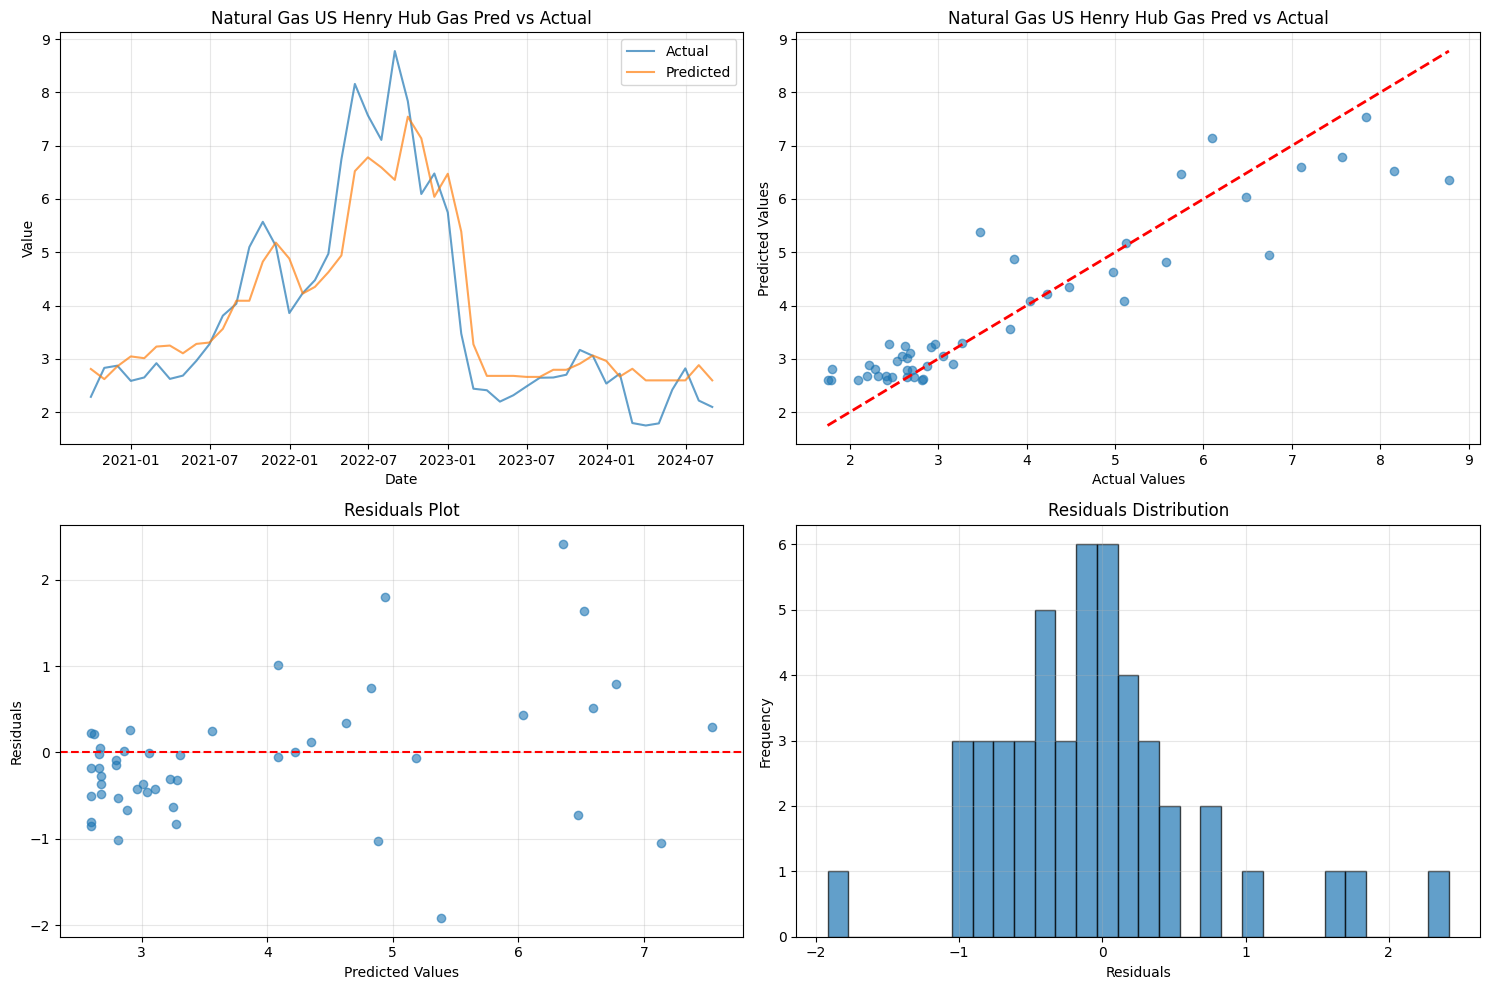

In [1571]:

def plot_predictions(actual, predicted, title="XGBoost Predictions"):

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(actual.index, actual.values, label='Actual', alpha=0.7)
    axes[0, 0].plot(actual.index, predicted, label='Predicted', alpha=0.7)
    axes[0, 0].set_title(f'{title}')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].scatter(actual.values, predicted, alpha=0.6)
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title(f'{title}')
    axes[0, 1].grid(True, alpha=0.3)

    residuals = actual.values - predicted
    axes[1, 0].scatter(predicted, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Predicted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Plot')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Residuals Distribution')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_predictions(xgb_actual_1, xgb_pred_1, "Natural Gas US Henry Hub Gas Pred vs Actual")

In [1558]:
pred_df1 = pd.DataFrame(xgb_pred_1)
pred_df1.index = test_data.index

pred_df2 = pd.DataFrame(xgb_pred_2)
pred_df2.index = test_data.index

pred_df3 = pd.DataFrame(xgb_pred_3)
pred_df3.index = test_data.index

pred_df1.columns = ['pred_1']
pred_df2.columns = ['pred_2']
pred_df3.columns = ['pred_3']

combined_df = pd.concat([pred_df1, pred_df2, pred_df3], axis=1)

combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'date'}, inplace=True)

combined_df.to_csv('submission_file.csv', index=False, encoding='utf-8')


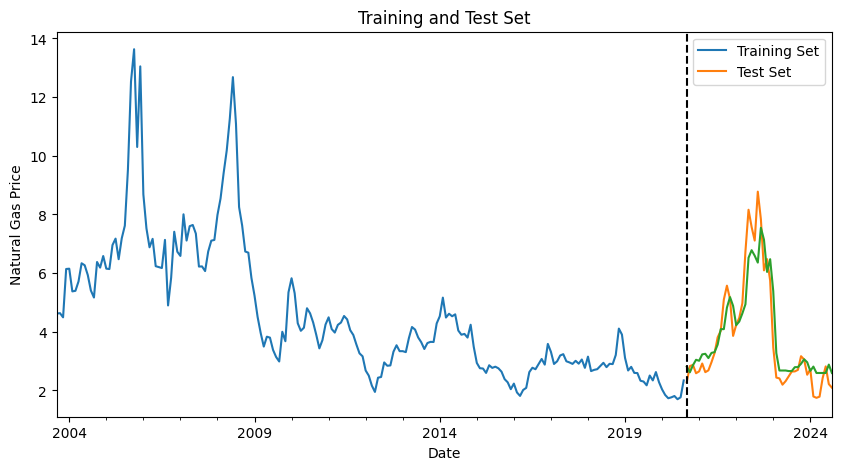

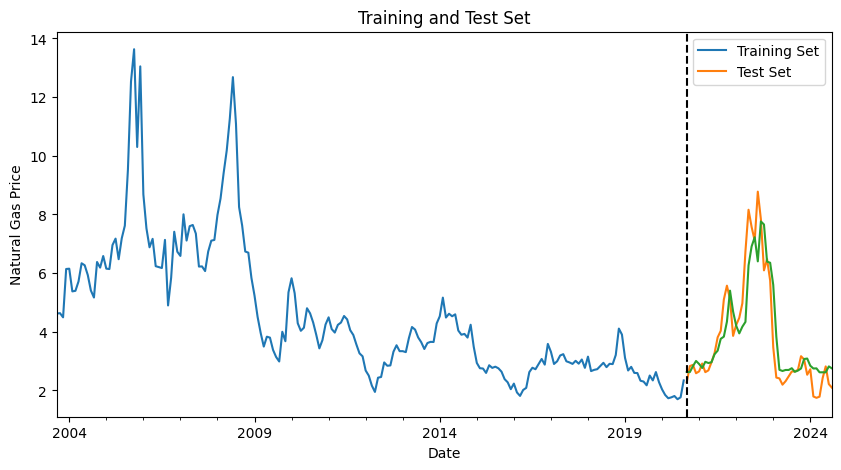

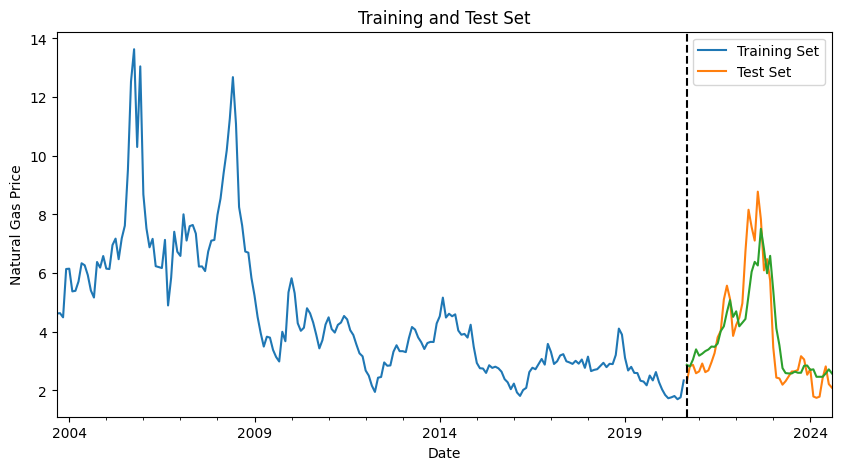

In [1559]:
def plot_test_with_preds(pred_df, num=1):
  fig, ax = plt.subplots(figsize=(10, 5))
  train_data.plot(ax=ax, label='Training Set')
  test_data.plot(ax=ax, label='Test Set')
  pred_df.plot(ax=ax, label=f'Predicted Set #{num}')
  ax.axvline('2020-09-30', color='black', ls='--')
  ax.legend(['Training Set', 'Test Set'])
  ax.set_title('Training and Test Set')
  ax.set_xlabel('Date')
  ax.set_ylabel('Natural Gas Price')
  plt.show()

plot_test_with_preds(pred_df1, 1)
plot_test_with_preds(pred_df2, 2)
plot_test_with_preds(pred_df3, 3)